In [1]:
# Import libraries (I dont need all of these - check later)
import aster_processing_fn
import numpy as np
import matplotlib.pyplot as plt
import gdal
import rasterio as rio
from gdalconst import GA_ReadOnly
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
from rasterio.mask import mask
from rasterio.plot import show
import os
from rasterio.features import shapes
from shapely.geometry import shape
import ogr
import sys
gdal.UseExceptions()

In [2]:
# Name airborne & aster files
airborne_tif = 'YOSEMITE_IR_PLANE_2017Apr21_mosaicked_9_calCam.tif'
aster_tif = 'AST_L1T_00304212017185107_20170422082541_26960_ImageData10.tif'
#out_tif = 'AST_L1T_00304212017185107_20170422082541_26960_ImageData10_masked9.tif'

In [3]:
# https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html

src_ds = gdal.Open(airborne_tif)
srcband = src_ds.GetRasterBand(1)

dst_layername = "POLYGONIZED_STUFF"
drv = ogr.GetDriverByName("ESRI Shapefile")
dst_ds = drv.CreateDataSource( dst_layername + ".shp" )
dst_layer = dst_ds.CreateLayer(dst_layername, srs = None )

air_polygob = gdal.Polygonize( srcband, None, dst_layer, -1, [], callback=None )

In [ ]:
# Use rasterio to create airborne mask
# Aster processing does not like this method
# https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons
mask = None
with rio.Env():
    with rio.open(airborne_tif) as src:
        image = src.read(1) # first band
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=mask, transform=src.transform)))

geoms = list(results)

#gpd_polygonized_raster = gpd.GeoDataFrame.from_features(geoms)

In [4]:
aster_masked = mask(aster_tif,air_polygob)

AttributeError: 'str' object has no attribute 'nodata'

In [ ]:
# Does not work either

# Convert airborne into shapefile to mask aster
inDs = gdal.Open('{}.tif'.format(airborne_tif))
outDs = gdal.Translate('{}.xyz'.format(airborne_tif), inDs, format='XYZ', creationOptions=["ADD_HEADER_LINE=YES"])
utDs = None
try:
    os.remove('{}.csv'.format(airborne_tif))
except OSError:
    pass
os.rename('{}.xyz'.format(airborne_tif), '{}.csv'.format(airborne_tif))
os.system('ogr2ogr -f "ESRI Shapefile" -oo X_POSSIBLE_NAMES=X* -oo Y_POSSIBLE_NAMES=Y* -oo KEEP_GEOM_COLUMNS=NO {0}.shp {0}.csv'.format(airborne_tif))

In [ ]:
# Does not work

# Create mask (modified from https://gis.stackexchange.com/questions/125202/gdal-clipping-a-raster-with-another-raster
# and https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html)
data = rio.open(aster_tif)
out_meta = data.meta.copy() 

air_mask = gdal.Open(airborne_tif, GA_ReadOnly)

geoTransform = air_mask.GetGeoTransform()
minx = geoTransform[0]
maxy = geoTransform[3]
maxx = minx + geoTransform[1] * air_mask.RasterXSize
miny = maxy + geoTransform[5] * air_mask.RasterYSize
bbox = box(minx, miny, maxx, maxy)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

coords = getFeatures(geo)

out_img, out_transform = mask(data, shapes=coords, crop=True)

with rio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)
    
masked = rio.open(out_tif)

In [6]:
# Call zonal stats function on masked aster
tb_mean, tb_max, tb_min, tb_std, masked_aster_tb = aster_processing_fn.zonal_stats(aster_tif, 10, 'SHAPE.shp', return_masked_array=True)

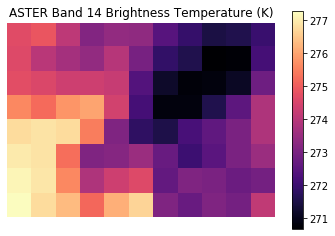

In [7]:
# Plot in Kelvin
plt.imshow(masked_aster_tb, cmap='magma')
plt.colorbar()
plt.title('ASTER Band 14 Brightness Temperature (K)');
plt.axis('off');

In [8]:
# Calculate temp in celsius
masked_aster_tb_C = masked_aster_tb-273.15

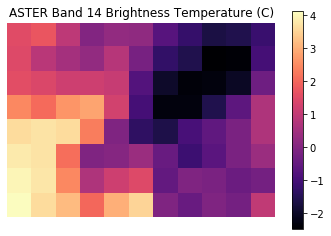

In [9]:
# Plot in celsius
plt.imshow(masked_aster_tb_C, cmap='magma')
plt.colorbar()
plt.title('ASTER Band 14 Brightness Temperature (C)');
plt.axis('off');

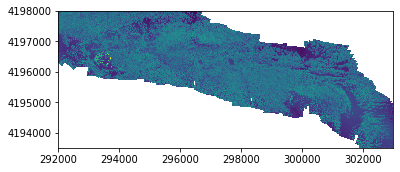

In [10]:
# Testing plotting airborne
filepath = 'YOSEMITE_IR_PLANE_2017Apr21_mosaicked_9_calCam.tif'
img = rio.open(filepath)

show((img,1))